# **4. Vision Transformers.**

In [ ]:
!pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 1.2 MB/s eta 0:00:00


In [ ]:
import torch
from torch import nn
from torch import nn, einsum
import torch.nn.functional as F
from torch import optim

from einops import rearrange, repeat
from einops.layers.torch import Rearrange
import numpy as np
import torchvision
import time

In [ ]:
torch.manual_seed(42)

DOWNLOAD_PATH = '/data/fashionmnist'
BATCH_SIZE_TRAIN = 100
BATCH_SIZE_TEST = 1000

transform_mnist = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize((0.1307,), (0.3081,))])

In [ ]:
train_set = torchvision.datasets.FashionMNIST(DOWNLOAD_PATH, train=True, download=True,
                                       transform=transform_mnist)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE_TRAIN, shuffle=True)

100%|██████████| 26421880/26421880 [00:01<00:00, 18524491.06it/s]


Extracting /data/fashionmnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to /data/fashionmnist/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 343351.06it/s]


Extracting /data/fashionmnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /data/fashionmnist/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 6048561.00it/s]


Extracting /data/fashionmnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /data/fashionmnist/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 5936837.23it/s]

Extracting /data/fashionmnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /data/fashionmnist/FashionMNIST/raw



In [ ]:
test_set = torchvision.datasets.FashionMNIST(DOWNLOAD_PATH, train=False, download=True,
                                      transform=transform_mnist)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE_TEST, shuffle=True)

In [ ]:
def pair(t):
    return t if isinstance(t, tuple) else (t, t)

# classes

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.ReLU(), #nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.attend = nn.Softmax(dim = -1)
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        b, n, _, h = *x.shape, self.heads
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = h), qkv)

        dots = einsum('b h i d, b h j d -> b h i j', q, k) * self.scale

        attn = self.attend(dots)

        out = einsum('b h i j, b h j d -> b h i d', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout = dropout))
            ]))
    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x

class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, pool = 'cls', channels = 3, dim_head = 64, dropout = 0., emb_dropout = 0.):
        super().__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_height, p2 = patch_width),
            nn.Linear(patch_dim, dim),
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)

        self.pool = pool
        self.to_latent = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, img):
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)

        x = self.transformer(x)

        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]

        x = self.to_latent(x)
        return self.mlp_head(x)

In [ ]:
model = ViT(image_size=28, patch_size=4, num_classes=10, channels=1, dim=64, depth=6, heads=4, mlp_dim=128)
optimizer = optim.Adam(model.parameters(), lr=0.003)

In [ ]:
model

ViT(
  (to_patch_embedding): Sequential(
    (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=4, p2=4)
    (1): Linear(in_features=16, out_features=64, bias=True)
  )
  (dropout): Dropout(p=0.0, inplace=False)
  (transformer): Transformer(
    (layers): ModuleList(
      (0-5): 6 x ModuleList(
        (0): PreNorm(
          (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (fn): Attention(
            (attend): Softmax(dim=-1)
            (to_qkv): Linear(in_features=64, out_features=768, bias=False)
            (to_out): Sequential(
              (0): Linear(in_features=256, out_features=64, bias=True)
              (1): Dropout(p=0.0, inplace=False)
            )
          )
        )
        (1): PreNorm(
          (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (fn): FeedForward(
            (net): Sequential(
              (0): Linear(in_features=64, out_features=128, bias=True)
              (1): ReLU()
              (2): Dr

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(count_parameters(model))

499722


In [ ]:
def train_epoch(model, optimizer, data_loader, loss_history):
    total_samples = len(data_loader.dataset)
    model.train()

    for i, (data, target) in enumerate(data_loader):
        optimizer.zero_grad()
        output = F.log_softmax(model(data), dim=1)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

        if i % 100 == 0:
            print('[' +  '{:5}'.format(i * len(data)) + '/' + '{:5}'.format(total_samples) +
                  ' (' + '{:3.0f}'.format(100 * i / len(data_loader)) + '%)]  Loss: ' +
                  '{:6.4f}'.format(loss.item()))
            loss_history.append(loss.item())

In [ ]:
def evaluate(model, data_loader, loss_history):
    model.eval()

    total_samples = len(data_loader.dataset)
    correct_samples = 0
    total_loss = 0

    with torch.no_grad():
        for data, target in data_loader:
            output = F.log_softmax(model(data), dim=1)
            loss = F.nll_loss(output, target, reduction='sum')
            _, pred = torch.max(output, dim=1)

            total_loss += loss.item()
            correct_samples += pred.eq(target).sum()

    avg_loss = total_loss / total_samples
    loss_history.append(avg_loss)
    print('\nAverage test loss: ' + '{:.4f}'.format(avg_loss) +
          '  Accuracy:' + '{:5}'.format(correct_samples) + '/' +
          '{:5}'.format(total_samples) + ' (' +
          '{:4.2f}'.format(100.0 * correct_samples / total_samples) + '%)\n')

In [ ]:
N_EPOCHS = 3

start_time = time.time()


train_loss_history, test_loss_history = [], []
for epoch in range(1, N_EPOCHS + 1):
    print('Epoch:', epoch)
    train_epoch(model, optimizer, train_loader, train_loss_history)
    evaluate(model, test_loader, test_loss_history)

print('Execution time:', '{:5.2f}'.format(time.time() - start_time), 'seconds')

Epoch: 1
[    0/60000 (  0%)]  Loss: 2.3207
[10000/60000 ( 17%)]  Loss: 0.5750
[20000/60000 ( 33%)]  Loss: 0.6389
[30000/60000 ( 50%)]  Loss: 0.5888
[40000/60000 ( 67%)]  Loss: 0.4696
[50000/60000 ( 83%)]  Loss: 0.4725

Average test loss: 0.5446  Accuracy: 7991/10000 (79.91%)

Epoch: 2
[    0/60000 (  0%)]  Loss: 0.3987
[10000/60000 ( 17%)]  Loss: 0.4435
[20000/60000 ( 33%)]  Loss: 0.5485
[30000/60000 ( 50%)]  Loss: 0.3124
[40000/60000 ( 67%)]  Loss: 0.3762
[50000/60000 ( 83%)]  Loss: 0.5514

Average test loss: 0.4940  Accuracy: 8212/10000 (82.12%)

Epoch: 3
[    0/60000 (  0%)]  Loss: 0.3055
[10000/60000 ( 17%)]  Loss: 0.4871
[20000/60000 ( 33%)]  Loss: 0.4090
[30000/60000 ( 50%)]  Loss: 0.5643
[40000/60000 ( 67%)]  Loss: 0.3769
[50000/60000 ( 83%)]  Loss: 0.5299

Average test loss: 0.4496  Accuracy: 8367/10000 (83.67%)

Execution time: 1201.46 seconds


In [ ]:
import matplotlib.pyplot as plt

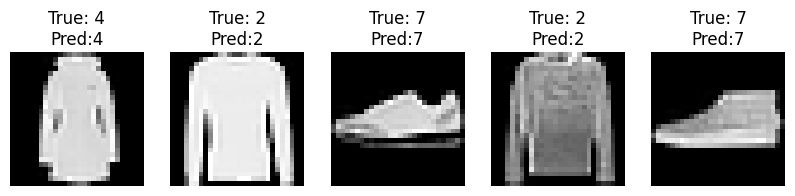

In [ ]:
model.eval()
images, labels = next(iter(test_loader))

with torch.no_grad():
 output = model(images)
 predicted_classes = output.argmax(dim=1)
 probabilities = torch.softmax(output, dim=1)
plt.figure(figsize=(10,4))
for index in np.arange(0,5):
 plt.subplot(1,5,index+1)
 img = images[index].cpu().squeeze()
 plt.imshow(img, cmap='gray')
 plt.title(f'True: {labels[index].item()}\nPred:{predicted_classes[index].item()}')
 plt.axis('off')
plt.show()

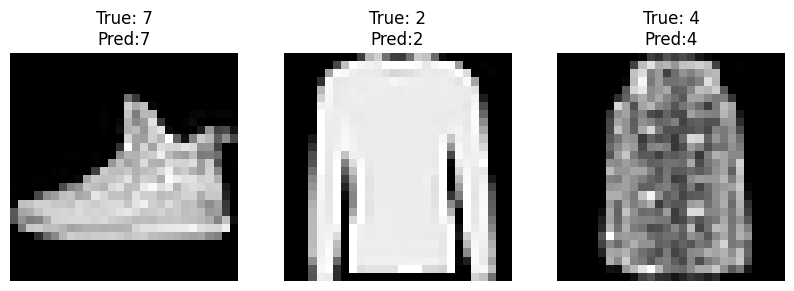

In [ ]:
random_indices = np.random.choice(len(images), 3, replace=False)
plt.figure(figsize=(10, 4))
for i, index in enumerate(random_indices):
 plt.subplot(1, 3, i + 1)
 img = images[index].cpu().squeeze()
 plt.imshow(img, cmap='gray')
 plt.title(f'True: {labels[index].item()}\nPred:{predicted_classes[index].item()}')
 plt.axis('off')
plt.show()

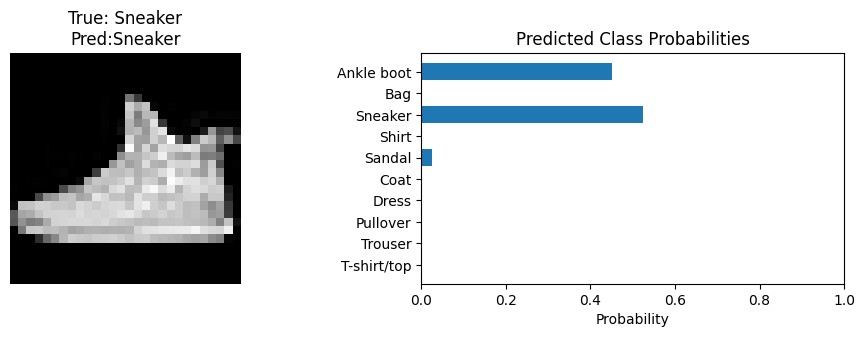

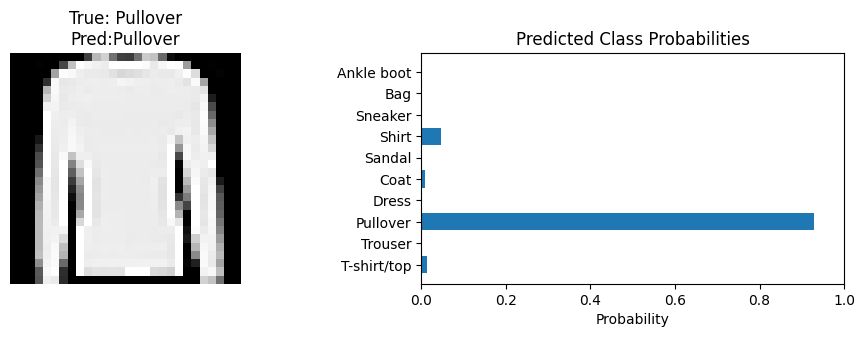

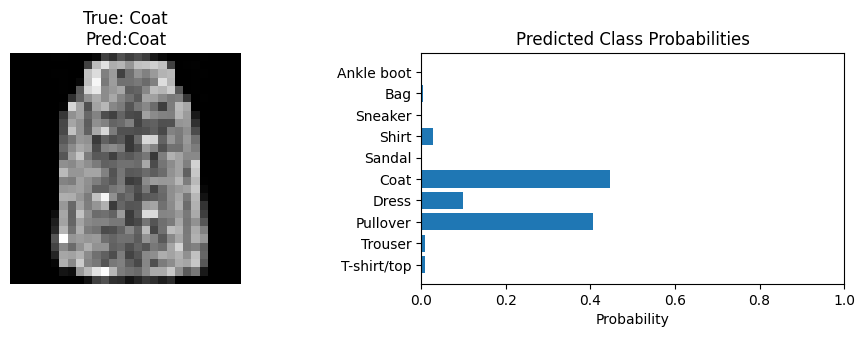

In [ ]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
for index in random_indices:
 img = images[index].cpu().squeeze()
 probs = probabilities[index].cpu().numpy()
 plt.figure(figsize=(12, 3))
 plt.subplot(1, 2, 1)
 plt.imshow(img, cmap='gray')
 plt.title(f'True: {class_names[labels[index].item()]}\nPred:{class_names[predicted_classes[index].item()]}')
 plt.axis('off')
 # Plotting the probabilities
 plt.subplot(1, 2, 2)
 plt.barh(class_names, probs)
 plt.xlabel('Probability')
 plt.title('Predicted Class Probabilities')
 plt.xlim(0, 1)
 plt.show()